In [77]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print(f'TensorFlow version: {tf.__version__}')

import math

nevergrad_benchmark = {}
x_star = {}
f_star = {}

rs = np.random.RandomState(seed=0)
n = 1000 # Dimension
@tf.function
def sphere(X):
    return tf.norm(X)**2
x_star["Sphere"] = tf.zeros((n,1))
f_star["Sphere"] = 0.

@tf.function
def Rosenbrock(X):
  res = tf.reduce_sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2)
  return res
nevergrad_benchmark["Rosenbrock"] = Rosenbrock
x_star["Rosenbrock"]= tf.constant(n * [1])
f_star["Rosenbrock"] = 0.

@tf.function
def rastrigin(X):
    A = 10.
    return A*n + tf.reduce_sum(X**2 - A *tf.math.cos(2. * math.pi * X))

nevergrad_benchmark["Rastrigin"] = rastrigin
x_star["Rastrigin"] = tf.constant(n*[0])
f_star["Rastrigin"] = 0

@tf.function
def lunacerk(X):
  s = 1 - 1/(2*tf.math.sqrt(22.)-8.2)
  mu_2 = -tf.math.sqrt((2.5**2-1.)/s)
  res = tf.minimum(tf.reduce_sum((X-2.5)**2), n + s*tf.reduce_sum((X-mu_2)**2)) + 10.*tf.reduce_sum(1-tf.math.cos(2.*math.pi*(X-2.5)))
  return res

nevergrad_benchmark["Lunacerk"] = lunacerk 
x_star["Lunacerk"] = tf.constant(n*[2.5])
f_star["Lunacerk"] = 0

A = rs.randn(n, n)
b = rs.randn(n, 1)

A = tf.convert_to_tensor(A, dtype=tf.float32)
b = tf.convert_to_tensor(b, dtype=tf.float32)

@tf.function
def ellipsoid(x):
    residual = tf.matmul(A,tf.reshape(x,(n,1))) - b
    loss = 0.5 * tf.norm(residual) ** 2 / float(n)
    return loss

x_star["Ellipsoid"] = np.linalg.lstsq(A, b, rcond=None)[0]
f_star["Ellipsoid"] = (0.5/float(n)) * np.linalg.norm(np.dot(A, x_star["Ellipsoid"]) - b) ** 2
nevergrad_benchmark["Ellipsoid"] = ellipsoid

TensorFlow version: 2.7.0


In [78]:
loss_and_grad_fun = nevergrad_benchmark["Ellipsoid"]
x_star = x_star["Ellipsoid"]
f_star = f_star["Ellipsoid"]

In [79]:
def VanillaES(loss_and_grad_fun, x, sigma = 0.1, beta = 1.0, learning_rate = 0.001, P = 10, N_Iter = 10000):

    n = tf.shape(x)[0]
    # Defines the distribution for sampling parameter perturbations.
    scale = sigma / np.sqrt(n)
    def sample():
        return scale * tf.random.normal(shape=(n, P), dtype=tf.float32)

    opt = tf.keras.optimizers.SGD(learning_rate)

    @tf.function
    def step_fun(x):
        epsilon = sample()
        
        f_pos = tf.reshape(tf.map_fn(loss_and_grad_fun, tf.transpose(x + epsilon)), (1,P))
        f_neg = tf.reshape(tf.map_fn(loss_and_grad_fun, tf.transpose(x-epsilon)), (1,P))
        
        # This update is a stochastic finite difference estimate of the true gradient.
        update = (beta / (2 * P * sigma ** 2)) * tf.reduce_sum((f_pos- f_neg)*epsilon, axis=1, keepdims=True)
        #Add a minus when you are solving RL tasks since we want to find the maximum
        opt.apply_gradients([(-update, x)]) 
        
        return loss_and_grad_fun(x)
    # Run the optmizer.
    fobj = []
    visited_states = []
    for i in range(N_Iter):
        fobj.append(step_fun(x))


    # Store training curve for plotting later.
    f_ves = tf.stack(fobj).numpy().copy()
    return f_ves

In [80]:
# Hyperparameters for GGES
import tensorflow_probability as tfp
tfk = tfp.math.psd_kernels

def GGES(loss_and_grad_fun, x, k=50, sigma = 0.1, beta = 1.0, alpha = 0.5, learning_rate = 0.0001, P = 10, N_Iter=10000):

    n = tf.shape(x)[0]

    a = sigma * np.sqrt(alpha / float(n))
    c = sigma * np.sqrt((1. - alpha) / float(k))

    # Defines the distribution for sampling parameter perturbations.
    scale = sigma / np.sqrt(n)
    def sample_Vanilla():
        return scale * tf.random.normal(shape=(n, 1), dtype=tf.float32)


    def sample(gradient_subspace):
        epsilon_full = tf.random.normal(shape=(n, P), dtype=tf.float32)
        epsilon_subspace = tf.random.normal(shape=(k+1, P), dtype=tf.float32)
        
        Q,_ = tf.linalg.qr(tf.transpose(gradient_subspace))
        epsilon = a * epsilon_full + c * tf.matmul(Q, epsilon_subspace)
        
        return epsilon

    opt = tf.keras.optimizers.SGD(learning_rate)

    def construct_states(states, x, i):
          states[i,:].assign(x[:,0])

    @tf.function
    def update_states(states, x):
          states.assign(tf.roll(states,-1,0))
          states[-1,:].assign(x[:,0])


    def construct_kernel(K, visited_states, x, i):
        k_i = tfk.ExponentiatedQuadratic(1, 0.1).apply(visited_states,tf.reshape(x,(1,n)))
        K[:-1,i].assign(k_i)
        K[i,:-1].assign(k_i)


    @tf.function
    def update_kernel(K, visited_states, x):
        K.assign(tf.roll(K,-1,0))
        K.assign(tf.roll(K,-1,1))
        k_star = tfk.ExponentiatedQuadratic(1, 0.1).apply(visited_states,tf.reshape(x,(1,n)))
        K[:-1,k].assign(k_star)
        K[k,:-1].assign(k_star)
        

    @tf.function
    def get_gradient(K, gradient):
        mu = tf.reshape(K[-1,:-1],(1,k)) @ tf.linalg.solve(K[:-1,:-1]+1e-6*tf.eye(k,k),gradient)
        return mu

    @tf.function
    def step_fun_Vanilla(x):
        epsilon = sample_Vanilla()
        # We utilize antithetic (positive and negative) samples.
        f_pos = loss_and_grad_fun(x + epsilon)
        f_neg = loss_and_grad_fun(x - epsilon)
        
        # This update is a stochastic finite difference estimate of the true gradient.
        update = (beta / (2 * sigma ** 2)) * (f_pos - f_neg) * epsilon
        # Add a minus for RL tasks since we want to find the maximum
        opt.apply_gradients([(-update, x)])
        
        return loss_and_grad_fun(x), update

    @tf.function
    def step_fun(x, future_gradient):
        epsilon = sample(future_gradient)
        # We utilize antithetic (positive and negative) samples.
        f_pos = tf.reshape(tf.map_fn(loss_and_grad_fun, tf.transpose(x + epsilon),dtype=tf.float32), (1,P))
        f_neg = tf.reshape(tf.map_fn(loss_and_grad_fun, tf.transpose(x-epsilon),dtype=tf.float32), (1,P))
        
        # This update is a stochastic finite difference estimate of the true gradient.
        update = (beta / (2 * P * sigma ** 2)) * tf.reduce_sum((f_pos- f_neg)*epsilon, axis=1, keepdims=True)
        # Add a minus for RL tasks since we want to find the maximum
        opt.apply_gradients([(-update, x)])
        
        return loss_and_grad_fun(x), update

    # Run the optmizer.
    fobj = []
    visited_states = tf.Variable(tf.zeros((k,n)),dtype=tf.float32)
    historic_gradient = tf.Variable(tf.zeros((k,n), dtype=tf.float32))
    K = tf.Variable(tf.zeros((k+1,k+1), dtype = tf.float32))
    for i in range(N_Iter):
        if i>k :
          future_gradient = get_gradient(K, historic_gradient)
        if i<k :
            loss, gradient = step_fun_Vanilla(x)
            construct_states(historic_gradient, gradient, i)
            construct_states(visited_states, tf.identity(x), i)
            construct_kernel(K, visited_states, tf.identity(x), i)
        elif i==k :
            loss, gradient = step_fun_Vanilla(x)
            update_states(historic_gradient, gradient)
            update_states(historic_gradient, gradient)
            construct_kernel(K, visited_states, tf.identity(x), i)
        else :
            loss, gradient = step_fun(x, tf.concat([historic_gradient,future_gradient],0))
            update_states(historic_gradient, gradient)
            update_kernel(K, visited_states, tf.identity(x))
            update_states(visited_states, tf.identity(x))
        fobj.append(loss)
    # Store training curve for plotting later.
    f_ges = tf.stack(fobj).numpy().copy()
    return f_ges

In [81]:
def SGES(loss_and_grad_fun, x, sigma = 0.1, beta = 1.0, learning_rate = 0.0001, delta = 1.2, k = 20, P = 10, N_Iter=10000):

    n = tf.shape(x)[0]
    p = 0.5
    # Defines the distribution for sampling parameter perturbations.
    a = sigma / np.sqrt(n)
    b = sigma * np.sqrt(1/n+1/k)

    def sample_Vanilla():
        return a * tf.random.normal(shape=(n, 1), dtype=tf.float32)


    def sample(historic_gradient, p, rng):
        # Compute the Singular Value Decomposition of the Historic Gradient
        S , U , _ = tf.linalg.svd(historic_gradient, full_matrices=True)
        # Retrieve the number of non null singular values
        M = tf.math.count_nonzero(tf.greater(S,1e-6),dtype=tf.int32)
        # Get the gradient space 
        U_Direct = U[:,:M]
        # Get the space orthogonal to the gradient space
        U_Orth = U[:,M:]
        # Compute the number of research distribution drawn from the gradient space
        # by getting a sample of binomial of parameters P and p
        N_Direct = rng.binomial(shape=[1],counts=[float(P)],probs=[p],dtype=tf.int32)[0]
        N_Orth = P-N_Direct
        # Compute the research directions according to the gadient space and its orthogonal
        epsilon_subspace = a*tf.random.normal(shape=(n, N_Direct), dtype=tf.float32)+b*U_Direct @ tf.random.normal(shape=(M, N_Direct), dtype=tf.float32)
        epsilon_orthogonal = a*tf.random.normal(shape=(n, N_Orth), dtype=tf.float32)+b*U_Orth @ tf.random.normal(shape=(n-M, N_Orth), dtype=tf.float32)
        return epsilon_subspace, epsilon_orthogonal, N_Direct

    opt = tf.keras.optimizers.SGD(learning_rate)


    def construct_states(states, x, i):
          # We create our states matrix
          states[:,i].assign(x[:,0])

    @tf.function
    def update_states(states, x):
          #We update the states by adding the last state and removing the first one (FIFO)
          states.assign(tf.roll(states,-1,1))
          states[:,-1].assign(x[:,0])


    @tf.function
    def step_fun_Vanilla(x):
        # We sample our research direction according to a Standard normal distribution
        epsilon = sample_Vanilla()
        # We utilize antithetic (positive and negative) samples.
        f_pos = loss_and_grad_fun(x + epsilon)
        f_neg = loss_and_grad_fun(x - epsilon)
        
        # This update is a stochastic finite difference estimate of the true gradient.
        update = (beta / (2 * sigma ** 2)) * (f_pos - f_neg) * epsilon
        # Add a minus for RL tasks since we want to find the maximum
        opt.apply_gradients([(-update, x)])
        
        return loss_and_grad_fun(x), update

    @tf.function
    def step_fun(x, historic_gradient, p, rng):
        # We sample our research direction from the historic gradient matrix
        epsilon_subspace, epsilon_othogonal, M = sample(historic_gradient, p, rng)

        epsilon = tf.concat([epsilon_subspace,epsilon_othogonal],1)
        # We utilize antithetic (positive and negative) samples.
        f_pos = tf.reshape(tf.map_fn(loss_and_grad_fun, tf.transpose(x + epsilon),dtype=tf.float32), (1,P))
        f_neg = tf.reshape(tf.map_fn(loss_and_grad_fun, tf.transpose(x-epsilon),dtype=tf.float32), (1,P))
        r = tf.cast(1/M,tf.float32) * tf.reduce_sum(tf.minimum(f_pos[:,:M], f_neg[:,:M]))
        r_Orth = tf.cast(1/(P-M), tf.float32) * tf.reduce_sum(tf.minimum(f_pos[:,M:], f_neg[:,M:]))
        # We update our hybrid distribution whose parameter is p
        if r > r_Orth :
          p = tf.minimum(delta*p,1)
        else :
          p = tf.maximum(1/delta*p,0)
        
        # This update is a stochastic finite difference estimate of the true gradient.
        update = (beta / (2*P * sigma ** 2)) * tf.reduce_sum((f_pos-f_neg)*epsilon, axis=1, keepdims=True)
        # Add a minus for RL tasks since we want to find the maximum
        opt.apply_gradients([(-update, x)])
        
        return loss_and_grad_fun(x), update
    
    # Run the optmizer.
    fobj = []
    visited_states = tf.Variable(tf.zeros((n,k)),dtype=np.float32)
    historic_gradient = tf.Variable(tf.zeros((n,k)),dtype=np.float32)
    rng = tf.random.Generator.from_seed(seed=232)
    for i in range(N_Iter):
        if i<k :
            loss, gradient = step_fun_Vanilla(x)
            construct_states(historic_gradient, gradient, i)
            construct_states(visited_states, tf.identity(x), i)
        elif i==k :
            loss, gradient = step_fun_Vanilla(x)
            update_states(historic_gradient, gradient)
            update_states(historic_gradient, gradient)
        else :
            loss, gradient = step_fun(x, historic_gradient, p, rng)
            update_states(historic_gradient, gradient)
            update_states(visited_states, tf.identity(x))
        fobj.append(loss)
    # Store training curve for plotting later.
    f_sges = tf.stack(fobj).numpy().copy()
    return f_sges

In [ ]:
%%time
x = tf.Variable(tf.constant(n*[[1.5]]),dtype=tf.float32)
f_ve, cosine_ves, var_ves = VanillaES(ellipsoid, x, learning_rate=0.1)

CPU times: user 1min 53s, sys: 2.06 s, total: 1min 55s
Wall time: 1min 34s


In [ ]:
%%time
x = tf.Variable(tf.constant(n*[[1.5]]),dtype=tf.float32)
f_ges, cosine_ges, var_ges = GGES(ellipsoid, x, sigma=0.1, learning_rate=0.1)

CPU times: user 3min 20s, sys: 5.28 s, total: 3min 25s
Wall time: 2min 26s


In [ ]:
%%time
x = tf.Variable(tf.constant(n*[[1.5]]),dtype=tf.float32)
f_sges, cosine_sges, var_sges = SGES(ellipsoid, x, sigma=0.1, learning_rate=0.1)

CPU times: user 4min 49s, sys: 27.1 s, total: 5min 17s
Wall time: 4min 5s


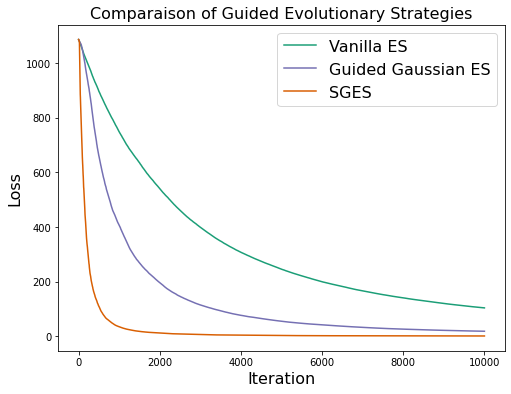

In [ ]:
COLORS = {'ges': '#7570b3', 'ves': '#1b9e77', 'sgdm': '#d95f02'}
plt.figure(figsize=(8, 6))
plt.plot(f_ve - f_star, color=COLORS['ves'], label='Vanilla ES')
plt.plot(f_ges - f_star, color=COLORS['ges'], label='Guided Gaussian ES')
plt.plot(f_sges - f_star, color=COLORS['sgdm'], label='SGES')
plt.legend(fontsize=16, loc=0)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Comparaison of Guided Evolutionary Strategies', fontsize=16);

from google.colab import files
plt.savefig("Comparaison of GES - Ellipsoid.pdf",format="pdf")

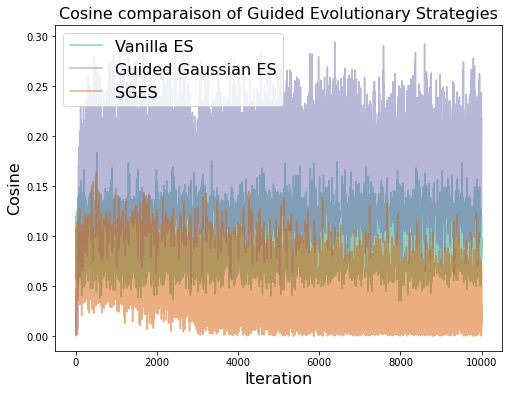

In [ ]:
COLORS = {'ges': '#7570b3', 'ves': '#1b9e77', 'sgdm': '#d95f02'}
plt.figure(figsize=(8, 6))
plt.plot(tf.math.abs(cosine_ves[:,0,0]), color=COLORS['ves'], label='Vanilla ES',alpha=0.5)
plt.plot(tf.math.abs(cosine_ges[:,0,0]), color=COLORS['ges'], label='Guided Gaussian ES',alpha=0.5)
plt.plot(tf.math.abs(cosine_sges[:,0,0]), color=COLORS['sgdm'], label='SGES',alpha=0.5)
plt.legend(fontsize=16, loc=0)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Cosine', fontsize=16)
plt.title('Cosine comparaison of Guided Evolutionary Strategies', fontsize=16);

from google.colab import files
plt.savefig("Cosine of GES - Ellipsoid.pdf",format="pdf")

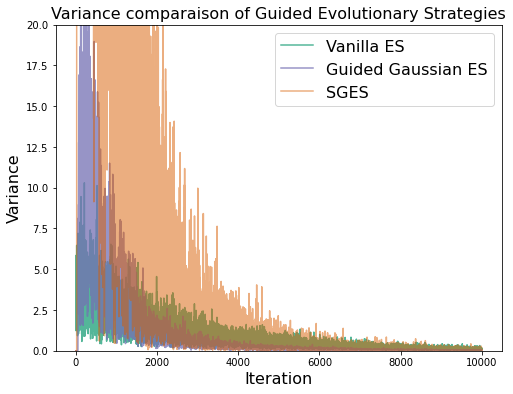

In [ ]:
COLORS = {'ges': '#7570b3', 'ves': '#1b9e77', 'sgdm': '#d95f02'}
plt.figure(figsize=(8, 6))
plt.plot(var_ves, color=COLORS['ves'], label='Vanilla ES',alpha=0.75)
plt.plot(var_ges, color=COLORS['ges'], label='Guided Gaussian ES',alpha=0.75)
plt.plot(var_sges, color=COLORS['sgdm'], label='SGES',alpha=0.5)
plt.ylim(top=20,bottom=0)
plt.legend(fontsize=16, loc=0)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Variance', fontsize=16)
plt.title('Variance comparaison of Guided Evolutionary Strategies', fontsize=16);

from google.colab import files
plt.savefig("Variance of GES - Ellipsoid.pdf",format="pdf")

In [ ]:
files.download("Variance of GES - Ellipsoid.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
!pip install tf_agents

In [83]:
import gym
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

environment_name = "CartPole-v0"
env = suite_gym.load(environment_name)
env = tf_py_environment.TFPyEnvironment(env)
input_shape = (4,)
model_initial = tf.keras.Sequential()
model_initial.add(tf.keras.layers.Dense(4, input_shape=input_shape, activation='relu'))
model_initial.add(tf.keras.layers.Dense(2, activation='softmax'))

@tf.function
def loss_and_grad_fun(x):
    current_position = 0
    # This part is used to transform our variable vector into the network matrix variavles
    for i in range(len(model.variables)):
      n = tf.shape(model.variables[i])[0]
      try :
          m = tf.shape(model.variables[i])[1]
          model.variables[i].assign(tf.reshape(x[current_position:(current_position+n*m)],(n,m)))
          current_position += n*m
      except ValueError :
          model.variables[i].assign(tf.reshape(x[current_position:(current_position+n)], [n]))
          current_position += n
    # Initialize the environnment and get the initial state s_0
    state = env.reset()
    score = tf.reshape(0.,[1])
    iteration = 0
    while not state.is_last() and iteration<300:
        #
        p = model(state.observation)[0]
        action = tf.math.argmax(p)
        state = env.step(action)
        score += state.reward
        iteration +=1
    return score

In [84]:
%%time
f_ves_5seeds = []
for i in range(5):
    print(i)
    model = tf.keras.models.clone_model(model_initial)
    list_var = []
    for matrix_variables in model.variables:
        n = tf.shape(matrix_variables)[0]
        try :
          m = tf.shape(matrix_variables)[1]
          list_var.append(tf.reshape(matrix_variables,(n*m,1)))
        except tf.errors.InvalidArgumentError :
          list_var.append(tf.reshape(matrix_variables,(n,1)))
    x = list_var[0]
    for i in  range(1,len(list_var)):
      x = tf.concat([x, list_var[i]],0)
    x = tf.Variable(x, dtype=tf.float32)
    f_ves = VanillaES(loss_and_grad_fun, x, N_Iter=100, learning_rate=0.05, sigma=1, P=20)
    f_ves_5seeds.append(f_ves)

0
1
2
3
4
CPU times: user 7min 49s, sys: 16.2 s, total: 8min 5s
Wall time: 6min 41s


In [85]:
%%time
f_ges_5seeds = []
for i in range(5):
    print(i)
    model = tf.keras.models.clone_model(model_initial)
    list_var = []
    for matrix_variables in model.variables:
        n = tf.shape(matrix_variables)[0]
        try :
          m = tf.shape(matrix_variables)[1]
          list_var.append(tf.reshape(matrix_variables,(n*m,1)))
        except tf.errors.InvalidArgumentError :
          list_var.append(tf.reshape(matrix_variables,(n,1)))
    x = list_var[0]
    for i in  range(1,len(list_var)):
      x = tf.concat([x, list_var[i]],0)
    x = tf.Variable(x, dtype=tf.float32)
    f_ges = GGES(loss_and_grad_fun, x, N_Iter=100, learning_rate=0.05, sigma=1, P=20, k=20)
    f_ges_5seeds.append(f_ges)

0
1
2
3
4
CPU times: user 24min 14s, sys: 55.4 s, total: 25min 9s
Wall time: 20min 3s


In [86]:
%%time
f_sges_5seeds = []
for i in range(5):
    print(i)
    model = tf.keras.models.clone_model(model_initial)
    llist_var = []
    for matrix_variables in model.variables:
        n = tf.shape(matrix_variables)[0]
        try :
          m = tf.shape(matrix_variables)[1]
          list_var.append(tf.reshape(matrix_variables,(n*m,1)))
        except tf.errors.InvalidArgumentError :
          list_var.append(tf.reshape(matrix_variables,(n,1)))
    x = list_var[0]
    for i in  range(1,len(list_var)):
      x = tf.concat([x, list_var[i]],0)
    x = tf.Variable(x, dtype=tf.float32)
    f_sges = SGES(loss_and_grad_fun, x, N_Iter=100, learning_rate=0.05, sigma=1, P=20, k=20)
    f_sges_5seeds.append(f_sges)

0
1
2
3
4
CPU times: user 32min 27s, sys: 1min 13s, total: 33min 40s
Wall time: 26min 52s


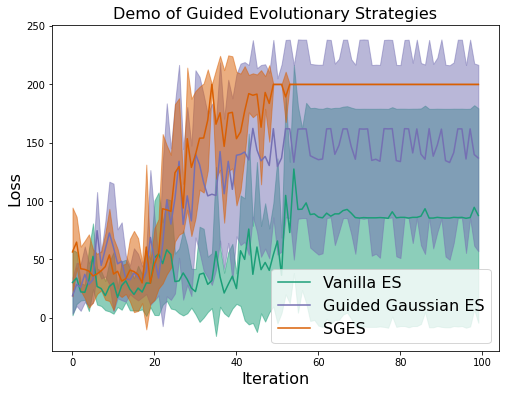

In [88]:
COLORS = {'ges': '#7570b3', 'ves': '#1b9e77', 'sgdm': '#d95f02'}
plt.figure(figsize=(8, 6))
plt.plot(tf.reduce_mean(tf.constant(f_ves_5seeds, shape=(5,100)),axis=0), color=COLORS['ves'], label='Vanilla ES')
plt.fill_between(range(100),
                 tf.reduce_mean(tf.constant(f_ves_5seeds, shape=(5,100)),axis=0)+ tf.math.reduce_std(tf.constant(f_ves_5seeds, shape=(5,100)),axis=0),
                 tf.reduce_mean(tf.constant(f_ves_5seeds, shape=(5,100)),axis=0)- tf.math.reduce_std(tf.constant(f_ves_5seeds, shape=(5,100)),axis=0),
                 color=COLORS['ves'], alpha=0.5)
plt.plot(tf.reduce_mean(tf.constant(f_ges_5seeds, shape=(5,100)),axis=0), color=COLORS['ges'], label='Guided Gaussian ES')
plt.fill_between(range(100),
                 tf.reduce_mean(tf.constant(f_ges_5seeds, shape=(5,100)),axis=0)+ tf.math.reduce_std(tf.constant(f_ges_5seeds, shape=(5,100)),axis=0),
                 tf.reduce_mean(tf.constant(f_ges_5seeds, shape=(5,100)),axis=0)- tf.math.reduce_std(tf.constant(f_ges_5seeds, shape=(5,100)),axis=0),
                 color=COLORS['ges'], alpha=0.5)
plt.plot(tf.reduce_mean(tf.constant(f_sges_5seeds, shape=(5,100)),axis=0) , color=COLORS['sgdm'], label='SGES')
plt.fill_between(range(100),
                 tf.reduce_mean(tf.constant(f_sges_5seeds, shape=(5,100)),axis=0)+ tf.math.reduce_std(tf.constant(f_sges_5seeds, shape=(5,100)),axis=0),
                 tf.reduce_mean(tf.constant(f_sges_5seeds, shape=(5,100)),axis=0)- tf.math.reduce_std(tf.constant(f_sges_5seeds, shape=(5,100)),axis=0),
                 color=COLORS['sgdm'], alpha=0.5)
plt.legend(fontsize=16, loc=0)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Demo of Guided Evolutionary Strategies', fontsize=16)
plt.savefig("Comparaison ES algortithm - CartPoleV0.pdf")

In [89]:
from google.colab import files
best_policy = x.numpy()
np.savetxt("Best Policy.txt", best_policy)
files.download("Best Policy.txt")
files.download("Comparaison ES algortithm - CartPoleV0.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Include this at the top of your colab code
import os
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc 
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc 
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete

try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco_py
  _mujoco_run_once = True

Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../0-libgl1-mesa-glx_20.0.8-0ubuntu1~18.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (20.0.8-0ubuntu1~18.04.1) ...
Selecting previously unselected package libglew2.0:amd64.
Preparing to unpack .../1-libglew2.0_2.0.0-5_amd64.deb ...
Unpacking libglew2.0:amd64 (2.0.0-5) ...
Selecting previously unselected package libglew-dev:amd64.
Preparing to unpack .../2-libglew-dev_2.0.0-5_amd64.deb ...
Unpacking libglew-dev:amd64 (2.0.0-5) ...
Selecting previously unselected package libglfw3:amd64.
Preparing to unpack .../3-libglfw3_3.2.1-1_amd64.deb ...
Unpacking libglfw3:amd64 (3.2.1-1) ...
Selecting previously unselected package patchelf.
Preparing to unpack .../4-patchelf_0.9-1_amd64.deb ...
Unpacking patchelf (0.9-1) ...
Selecting previously unselected package libosmesa6:amd64.
Preparing to unpack .../5-libosmesa6_20.0.8-0ubuntu1~18.0

In [90]:
environment_name = "HalfCheetah-v2"
env = suite_gym.load(environment_name)
env = tf_py_environment.TFPyEnvironment(env)
input_shape = (17,)
model_initial = tf.keras.Sequential()
model_initial.add(tf.keras.layers.Dense(17, input_shape=input_shape, activation='relu'))
model_initial.add(tf.keras.layers.Dense(6, activation='softmax'))

@tf.function
def loss_and_grad_fun(x):
    current_position = 0
    # This part is used to transform our variable vector into the network matrix variavles
    for i in range(len(model.variables)):
      n = tf.shape(model.variables[i])[0]
      try :
          m = tf.shape(model.variables[i])[1]
          model.variables[i].assign(tf.reshape(x[current_position:(current_position+n*m)],(n,m)))
          current_position += n*m
      except ValueError :
          model.variables[i].assign(tf.reshape(x[current_position:(current_position+n)], [n]))
          current_position += n
    # Initialize the environnment and get the initial state s_0
    state = env.reset()
    score = tf.reshape(0.,[1])
    iteration = 0
    while not state.is_last() and iteration<4000:
        p = model(state.observation)[0]
        action = tf.math.argmax(p)
        state = env.step(action)
        score += state.reward
        iteration +=1
    return score

In [ ]:
%%time
loss_and_grad_fun(x)

In [ ]:
%%time
f_ves_5seeds = []
for i in range(1):
    print(i)
    model = tf.keras.models.clone_model(model_initial)
    list_var = []
    for matrix_variables in model.variables:
        n = tf.shape(matrix_variables)[0]
        try :
          m = tf.shape(matrix_variables)[1]
          list_var.append(tf.reshape(matrix_variables,(n*m,1)))
        except tf.errors.InvalidArgumentError :
          list_var.append(tf.reshape(matrix_variables,(n,1)))
    x = list_var[0]
    for i in  range(1,len(list_var)):
      x = tf.concat([x, list_var[i]],0)
    x = tf.Variable(x, dtype=tf.float32)
    f_ves = VanillaES(loss_and_grad_fun, x, N_Iter=100, learning_rate=0.02, sigma=0.025, P=8)
    f_ves_5seeds.append(f_ves)

In [ ]:
%%time
f_ges_5seeds = []
for i in range(1):
    print(i)
    model = tf.keras.models.clone_model(model_initial)
    list_var = []
    for matrix_variables in model.variables:
        n = tf.shape(matrix_variables)[0]
        try :
          m = tf.shape(matrix_variables)[1]
          list_var.append(tf.reshape(matrix_variables,(n*m,1)))
        except tf.errors.InvalidArgumentError :
          list_var.append(tf.reshape(matrix_variables,(n,1)))
    x = list_var[0]
    for i in  range(1,len(list_var)):
      x = tf.concat([x, list_var[i]],0)
    x = tf.Variable(x, dtype=tf.float32)
    f_ges = GGES(loss_and_grad_fun, x, N_Iter=100, learning_rate=0.02, sigma=0.025, P=8, k=10)
    f_ges_5seeds.append(f_ges)

In [ ]:
%%time
f_sges_5seeds = []
for i in range(1):
    print(i)
    model = tf.keras.models.clone_model(model_initial)
    llist_var = []
    for matrix_variables in model.variables:
        n = tf.shape(matrix_variables)[0]
        try :
          m = tf.shape(matrix_variables)[1]
          list_var.append(tf.reshape(matrix_variables,(n*m,1)))
        except tf.errors.InvalidArgumentError :
          list_var.append(tf.reshape(matrix_variables,(n,1)))
    x = list_var[0]
    for i in  range(1,len(list_var)):
      x = tf.concat([x, list_var[i]],0)
    x = tf.Variable(x, dtype=tf.float32)
    f_sges = SGES(loss_and_grad_fun, x, N_Iter=100, learning_rate=0.02, sigma=0.025, P=8, k=10)
    f_sges_5seeds.append(f_sges)

In [ ]:
COLORS = {'ges': '#7570b3', 'ves': '#1b9e77', 'sgdm': '#d95f02'}
plt.figure(figsize=(8, 6))
plt.plot(f_ves, color=COLORS['ves'], label='Vanilla ES')
plt.plot(f_ges, color=COLORS['ges'], label='Guided Gaussian ES')
plt.plot(f_sges, color=COLORS['sgdm'], label='SGES')
plt.legend(fontsize=16, loc=0)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.savefig("Comparaison ES algortithm - CartPoleV0.pdf")